# Package ingest

In [104]:
# Importing Python packages

import pandas as pd
import numpy as np
import plotnine as p9
import os
import geopandas as gpd
from pathlib import Path


# Data ingest

In [105]:
# Reading in phased development data

phased_development = pd.read_csv('pipeline_example_output.csv').drop(['Unnamed: 0'],axis = 1)
phased_development.head(2)

,ProjectID,land_use,year,percent_development_pa,status,development_pa
0,Riyadh,Residential - Villas Emiratis (Units),2024,1.0,Under Construction,0.0
1,2100.0,Residential - Villas Emiratis (Units),2024,1.0,Under Construction,944300.0


In [106]:
# Bringing in information about whether TAZs will include demolition of existing floorspace

demolition_input = pd.read_csv('test_mp_data.csv')

# Trimming the dataframe down to masterplan ids and the column indication whether existing floorspace will be demolished or not

demolition_input = demolition_input[['ProjectID','Demolition or No Demolition']]
demolition_input = demolition_input.rename({'ProjectID':'masterplan_projectid'},axis = 1)
demolition_input.head(2)

,masterplan_projectid,Demolition or No Demolition
0,Riyadh,No
1,Samha New Housing - Ph 3,No


In [107]:
# Reading in baseline TAZ data

sharepoint_path = f'C:/Users/{os.environ.get( "USERNAME" )}/Buro Happold'
project_path = Path(f"{sharepoint_path}/P060927 Plan Capital 2040 - 02_Documents/11_GIS/05 Urban Models")
ium_path = os.path.join(project_path,'ium_ad.gpkg')
zone_taz_2022 = gpd.read_file(ium_path, layer='zone_taz_2022')
zone_taz_2022.head(2)


,Z,SHAPE_Length,SHAPE_Area,NUM_OF_BUILDINGS,Calc_Total_Ex_GFA,Ex_GFA,RES_GFA,Residential_Labour_GFA,OFFICE_GFA,RETAIL_GFA,...,RETMAL_PRO,MEDCLI_PRO,MEDHOS_PRO,NONTER_PRO,TER_PRO,SCHPLCS_NT,SCHPLCS_TE,SCHPLCS_PR,SCHPLCS_SE,geometry
0,1044,47079.0,606869.0,679.0,297016.0,297542.0,271410.0,0.0,0.0,0.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((270352.336 2727199.707, 269735..."
1,1310,98338.0,6727847.0,541.0,223794.0,224058.0,152630.0,0.0,0.0,6490.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((278888.425 2680518.149, 278729..."


In [108]:
# Bringing in MP to TAZ development deltas

zone_taz_delta = gpd.read_file(ium_path, layer='zone_taz_delta')
zone_taz_delta.head(2)


,Z,ZONE,EPA,UPC_PRECIN,PRECINCT_N,ST_DIST_ID,ST_DIST_EN,UDM_DIST_I,UDM_DIST_E,REGION,...,score_component_rank_sum_rank_mp,score_component_rank_mean_rank_mp,score_component_rank_sum_rank_urban,score_component_rank_mean_rank_urban,score_development_priority,2022_taz_far,gfa_per_ha,landmodel_limit_gfa_per_ha,landmodel_limit_gfa_per_ha_delta,geometry
0,2510,2510,None,1.0,Abu Dhabi,1.0,Abu Dhabi West Coast And Islands And Mussaffah...,500.0,ABU AL ABYAD ISLAND,ADM,...,NaN,NaN,1.000000,1.000000,5.0,0.000003,0.026657,0.026657,-0.025877,"MULTIPOLYGON (((182767.838 2687320.951, 183001..."
1,2001,2001,None,31.0,Ghantoot,90.0,Al Jarf (Hizam Al Ghabat)_N,1061.0,AL JARF (HIZAM AL GHABAT),ADM,...,NaN,NaN,0.928981,0.928981,5.0,0.000012,0.114820,0.114820,-0.111672,"MULTIPOLYGON (((292136.563 2740372.904, 291924..."


In [109]:
# Creating a dataframe containing an MP to TAZ mappong

mp_taz_crosswalk = zone_taz_delta[['ZONE','masterplan_projectid']]
mp_taz_crosswalk.head(2)

,ZONE,masterplan_projectid
0,2510,None
1,2001,None


In [110]:
# Increasing the development capacity limits by a multiplier for prototyping purposes
zone_taz_delta['landmodel_limit_gfa_per_ha']  = zone_taz_delta['landmodel_limit_gfa_per_ha']
zone_taz_delta['max_capacity_gfa'] =  zone_taz_delta['AREA'] * 100000#zone_taz_delta['landmodel_limit_gfa_per_ha']
zone_taz_delta.head(2)

,Z,ZONE,EPA,UPC_PRECIN,PRECINCT_N,ST_DIST_ID,ST_DIST_EN,UDM_DIST_I,UDM_DIST_E,REGION,...,score_component_rank_mean_rank_mp,score_component_rank_sum_rank_urban,score_component_rank_mean_rank_urban,score_development_priority,2022_taz_far,gfa_per_ha,landmodel_limit_gfa_per_ha,landmodel_limit_gfa_per_ha_delta,geometry,max_capacity_gfa
0,2510,2510,None,1.0,Abu Dhabi,1.0,Abu Dhabi West Coast And Islands And Mussaffah...,500.0,ABU AL ABYAD ISLAND,ADM,...,NaN,1.000000,1.000000,5.0,0.000003,0.026657,0.026657,-0.025877,"MULTIPOLYGON (((182767.838 2687320.951, 183001...",31473845.0
1,2001,2001,None,31.0,Ghantoot,90.0,Al Jarf (Hizam Al Ghabat)_N,1061.0,AL JARF (HIZAM AL GHABAT),ADM,...,NaN,0.928981,0.928981,5.0,0.000012,0.114820,0.114820,-0.111672,"MULTIPOLYGON (((292136.563 2740372.904, 291924...",2987273.0


In [111]:
# Calculating gfa development capacity caps for each TAZ

taz_max_capacities = zone_taz_delta[['ZONE','masterplan_projectid','AREA','landmodel_limit_gfa_per_ha','2022_Calc_Total_Ex_GFA']]
taz_max_capacities['max_capacity_gfa'] = taz_max_capacities['AREA'] * 100000 #taz_max_capacities['landmodel_limit_gfa_per_ha']
taz_max_capacities = taz_max_capacities[['ZONE','masterplan_projectid','max_capacity_gfa','2022_Calc_Total_Ex_GFA']]

taz_max_capacities.head(5)

C:\Users\jtindale\AppData\Local\Temp\ipykernel_14656\1167103205.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ZONE,masterplan_projectid,max_capacity_gfa,2022_Calc_Total_Ex_GFA
0,2510,None,31473845.0,839.0
1,2001,None,2987273.0,343.0
2,1323,None,30586472.0,7368.0
3,1321,None,5742057.0,31.0
4,3372,5000.34,306214.0,435.0


c:\Users\jtindale\AppData\Local\miniforge3\envs\landmodel\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 57'. Pick better value with 'binwidth'.


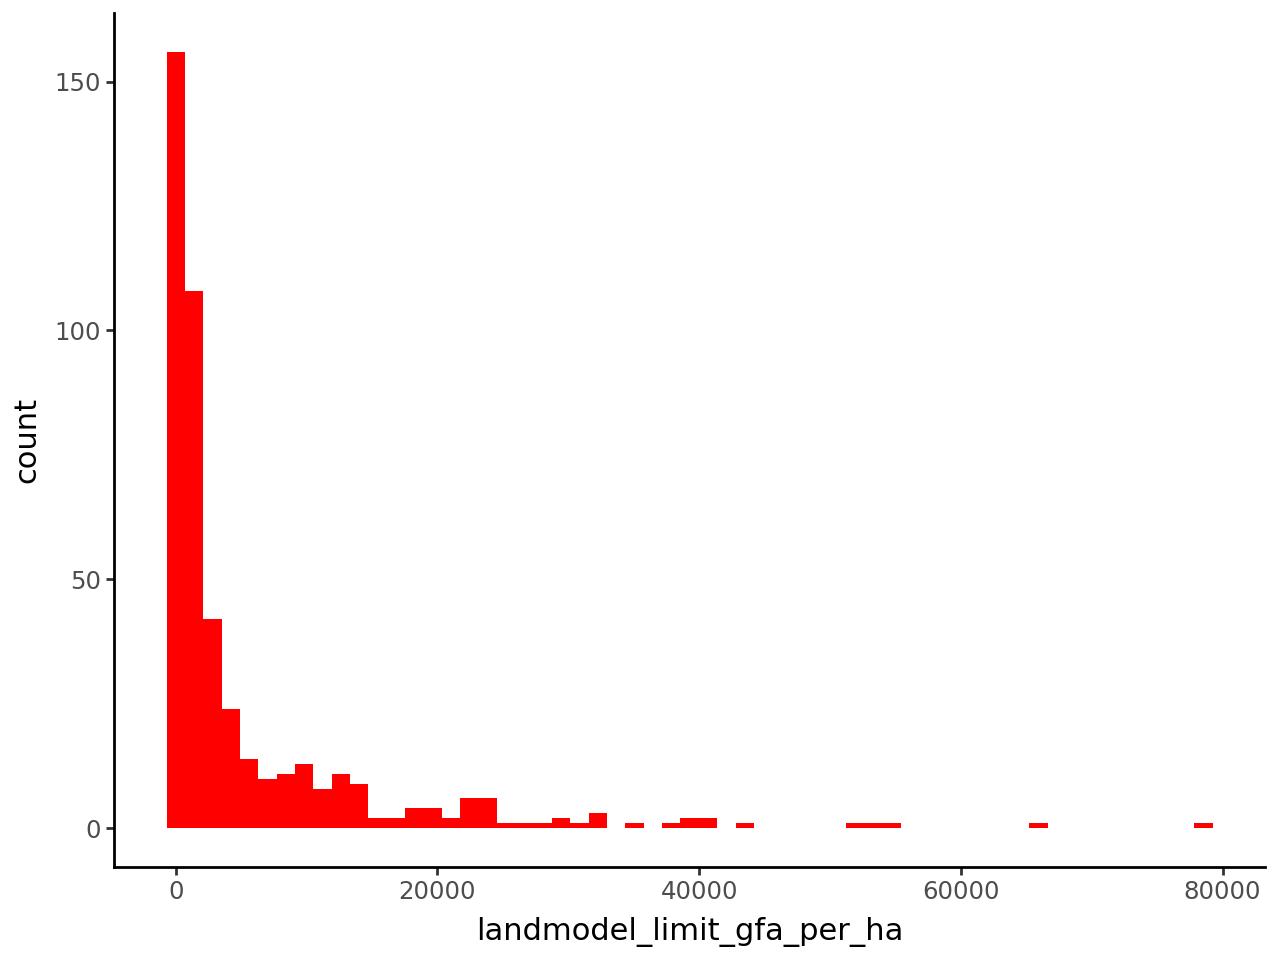

In [112]:
# Checking densities per ha from the GIS package by bin

densities = zone_taz_delta[['masterplan_projectid','landmodel_limit_gfa_per_ha']]
densities = densities[~densities['masterplan_projectid'].isna()]
densities = densities.sort_values(by = ['landmodel_limit_gfa_per_ha']).dropna()
(p9.ggplot(densities,p9.aes(x = 'landmodel_limit_gfa_per_ha')) +
 p9.geom_histogram(fill = 'red') +
 p9.theme_classic())

In [113]:
# Creating a dataframe that identifies available capacity for development in each TA|

taz_available_capacity = zone_taz_delta[['ZONE','masterplan_projectid','2022_Calc_Total_Ex_GFA','max_capacity_gfa','score_component_rank_sum_rank_mp']]
taz_available_capacity = taz_available_capacity[~taz_available_capacity['masterplan_projectid'].isna()]
taz_available_capacity = taz_available_capacity.merge(demolition_input,how = 'left', on = 'masterplan_projectid')
taz_available_capacity['2022_Calc_Total_Ex_GFA'] = taz_available_capacity.apply(lambda row: 0 if row['Demolition or No Demolition'] == 'Yes' else row['2022_Calc_Total_Ex_GFA'],axis =1)
taz_available_capacity['available_capacity'] = taz_available_capacity['max_capacity_gfa'] - taz_available_capacity['2022_Calc_Total_Ex_GFA']
taz_available_capacity.head(50)


,ZONE,masterplan_projectid,2022_Calc_Total_Ex_GFA,max_capacity_gfa,score_component_rank_sum_rank_mp,Demolition or No Demolition,available_capacity
0,3372,5000.34,435.0,306214.0,0.690141,No,305779.0
1,2519,1164.0,75.0,19384.0,0.800000,NaN,19309.0
2,2031,5000.0,70.0,128397.0,0.488636,NaN,128327.0
3,86,1007.38,145.0,10456.0,0.757576,No,10311.0
4,2361,1113.3.3,34.0,6328.0,0.740000,No,6294.0
5,3203,1113.3.3,34.0,2158.0,0.440000,No,2124.0
6,1977,5000.0,178.0,72022.0,0.227273,NaN,71844.0
7,2953,5000.0,313.0,44608.0,0.931818,NaN,44295.0
8,2023,5000.0,1135.0,111429.0,0.636364,NaN,110294.0
9,806,1996.0,26631.0,3328815.0,1.000000,NaN,3302184.0


In [114]:
# Removing TAZs where there is no available capacity

taz_available_capacity['available_capacity'] = taz_available_capacity['available_capacity'].apply(lambda x: 0 if pd.isna(x) or x < 0 else x)
taz_available_capacity = taz_available_capacity[taz_available_capacity['available_capacity'] > 0]
taz_available_capacity.head(50)


,ZONE,masterplan_projectid,2022_Calc_Total_Ex_GFA,max_capacity_gfa,score_component_rank_sum_rank_mp,Demolition or No Demolition,available_capacity
0,3372,5000.34,435.0,306214.0,0.690141,No,305779.0
1,2519,1164.0,75.0,19384.0,0.800000,NaN,19309.0
2,2031,5000.0,70.0,128397.0,0.488636,NaN,128327.0
3,86,1007.38,145.0,10456.0,0.757576,No,10311.0
4,2361,1113.3.3,34.0,6328.0,0.740000,No,6294.0
5,3203,1113.3.3,34.0,2158.0,0.440000,No,2124.0
6,1977,5000.0,178.0,72022.0,0.227273,NaN,71844.0
7,2953,5000.0,313.0,44608.0,0.931818,NaN,44295.0
8,2023,5000.0,1135.0,111429.0,0.636364,NaN,110294.0
9,806,1996.0,26631.0,3328815.0,1.000000,NaN,3302184.0


In [115]:
# Picking out masterplan ids from those with available capacity

mp_available_capacity_list = taz_available_capacity[['masterplan_projectid']].drop_duplicates()
mp_available_capacity_list = mp_available_capacity_list['masterplan_projectid'].tolist()
print(mp_available_capacity_list)

['5000.34', '1164.0', '5000.0', '1007.38', '1113.3.3', '1996.0', '1007.45', '1001.8.1', '39724.0', '1633.0', '1997.0', '2154.0', 'Al Faya Industrial - New', '1114.0', '15090.1', '1995.0', '1113.11', '26239.0', '1007.42.4', 'Riyadh', '1413.0', '1113.6', '32379.0', '1072.0', '12222.0', '21301.0', '2100.0', 'ICAD 1', '17407.0', '25087.0', '1089.62', '17860.0', '1113.8.1', '12805.0', '1137.0', '1994.0', '5222.0', '1007.27', '1116.5', '1443.0', '1097.40', '1089.65', '1113.25', '25983.0', '1007.42.1', '5365.0', '1097.34', '1119.0', '1001.21', '18932.0', '26626.0', '2115.2.1', '6003.0', '1113.4', '1086.3', '1235.0']


In [116]:
# Creating function for creating dataframes with the cumulative capacity across TAZs in an MP and then ordering them based on the TAZ's scores

def cumulative_capacity_function(mp_list):
    
    df_list = []
    
    for mp in mp_list:
        
        df = taz_available_capacity[taz_available_capacity['masterplan_projectid'] == mp].sort_values(by=['score_component_rank_sum_rank_mp'],ascending = False).reset_index(drop = True)
        df['cum_development'] = df['available_capacity'].cumsum()
        df = df[['masterplan_projectid','ZONE','cum_development']].reset_index(drop =True)
        df_list.append(df) 
    # Concatenate all DataFrames in the list along the rows (axis=0)
    result_df = pd.concat(df_list, axis=0)
    
    return result_df

# Running function

taz_cumulative_capacity = cumulative_capacity_function(mp_available_capacity_list)
taz_cumulative_capacity.head(3)


,masterplan_projectid,ZONE,cum_development
0,5000.34,3372,305779.0
1,5000.34,1998,633473.0
2,5000.34,3358,895619.0


In [117]:
# Creating a dataframe that contains cumulative development by masterplan per year

mp_cumulative_development= phased_development[['ProjectID', 'year', 'development_pa']]
mp_cumulative_development['cumulative_development'] = mp_cumulative_development.groupby(['ProjectID', 'year'])['development_pa'].cumsum().reset_index(drop=True)
mp_cumulative_development = mp_cumulative_development.drop(['development_pa'],axis=1).drop_duplicates().reset_index(drop = True)
mp_cumulative_development['cumulative_development'] = mp_cumulative_development['cumulative_development'].astype(float)
mp_cumulative_development = mp_cumulative_development[mp_cumulative_development['cumulative_development'] > 0].reset_index(drop = True)
mp_cumulative_development.head(2)

C:\Users\jtindale\AppData\Local\Temp\ipykernel_14656\2400619848.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ProjectID,year,cumulative_development
0,2100.0,2024,944300.0
1,1994.0,2024,615600.0


In [118]:
# Defining a function that allocates total development to MPs to TAZs

def mp_to_taz_function(mp_id):
    
    df = taz_cumulative_capacity[taz_cumulative_capacity['masterplan_projectid'] == mp_id]
    df_2 = mp_cumulative_development[mp_cumulative_development['ProjectID'] == mp_id]
    df_2 = df_2.groupby('year')['cumulative_development'].sum().reset_index()
    df_2['cumulative_development'] = df_2['cumulative_development'].cumsum()
    
    # Create a copy of the test DataFrame
    df_3 = df.copy()
    # Iterate over the columns and indices
    for col, idx in zip(df_2['year'], df_2['cumulative_development']):
        # Create a boolean mask where 'cum_development' is less than 'idx'
        mask = df_3['cum_development'] < idx
        # Apply the mask to update the column with 'cum_development' values or 0
        df_3[col] = df_3['cum_development'].where(mask, 0)

    df_3 = df_3.melt(id_vars = ['masterplan_projectid','ZONE','cum_development']).rename({'variable':'year'},axis = 1)
    df_3 = df_3.merge(df_2,how = 'left',on = 'year')
    df_3['value_2'] = df_3.apply(lambda row: 0 if row['value'] != 0 else  row['cumulative_development'] - row['cum_development'],axis = 1)
    
    df_3_split= df_3[['ZONE','year','value_2']]
    df_3_split = df_3_split[df_3_split['value_2'] != 0]

    # Group by 'year' and find the index of the minimum 'value'
    idx = df_3_split.groupby('year')['value_2'].idxmax()

    # Select the rows that correspond to the minimum value in each year
    df_3_split = df_3_split.loc[idx]
    df_3_split = df_3_split.merge(df_2,how = 'left', on = 'year')
    df_3_split['value_2'] = df_3_split['cumulative_development']
    df_3_split = df_3_split[['ZONE','year','value_2']].rename({'value_2':'value'},axis = 1)

    df_3_split_2 = df_3[['ZONE','year','value']]
    df_3_split_2 = df_3_split_2[df_3_split_2['value'] != 0]
    results_df = pd.concat([df_3_split,df_3_split_2],axis = 0).sort_values(['year','value']).reset_index(drop = True)
    return(results_df)

In [119]:
# Creating a list of masterplan IDs to feed into the MP to TAZ function

mp_ids = mp_cumulative_development['ProjectID'].drop_duplicates().tolist()
print(mp_ids)

['2100.0', '1994.0', '1089.62', '1042.0', '1097.34', '1085.0', '1740.0', '1235.0', '1114.1', '1113.8', '5365.0', '1113.9', '1119.0', '21227.0', '1413.0', '24996.0', '23168.0', '1113.6', '2897.0', '12222.0', '1113.27', '2115.2.1', 'Riyadh', '1996.0', '1995.0', 'ICAD 1', '1146.0', '1097.40', '1633.0', '1032.0', '1113.3.3', '6029.0', '6033.0', '1236.0', '1086.3', '1089.56', '1783.0', '26626.0', '25983.0', '35581.0', '32379.0', '5000.34', '12698.0', '18495.2', '6034.0', '38190.0', '1007.42.1', '1113.6.12.4', '1113.6.12.2', '17158.3', '5746.0', '32592.0', '24640.0', '11220.0', '1113.24.x', '18211.0', '1113.17', '33436.0', '21661.0', '1113.21', '15090.1', '21257.0', '15694.0', '1113.28', '5222.0', '17158.0', '17158.4', '21301.0', '1113.6.12.3', '26239.0', '18932.0', '1113.6.12.1', '21592.0', '39724.0', '25258.0', '17860.0', '24811.0', '18916.0', 'Z9_MBZ', '21703.0', '33416.0', '36016.0', '33450.0', '1137.0', '1007.38', '1007.42.4', '1997.1', '1089.65', '1113.16', '23037.0', '15690.0', '5251.

In [120]:
# Creating a list to contain the results of running the phasing function

mp_to_taz_results = []

# Running the function through a for loop

for mp_id in mp_ids:
    my_df = mp_to_taz_function(mp_id)  # Assume mp_to_taz_function is defined and returns a DataFrame
    mp_to_taz_results.append(my_df)

# Concatenating dataframes generated by running the loops and printing the head

mp_to_taz_phasing = pd.concat(mp_to_taz_results, axis=0).reset_index(drop = True)
mp_to_taz_phasing = mp_to_taz_phasing.merge(mp_taz_crosswalk, how= 'left', on = 'ZONE').rename({'masterplan_projectid':'ProjectID'},axis = 1) # Merging on masterplan IDs for the next stage of the calculation process
mp_to_taz_phasing.head(3)


,ZONE,year,value,ProjectID
0,3129,2024,81194.0,2100.0
1,960,2024,220760.0,2100.0
2,3125,2024,310991.0,2100.0


In [121]:
# Creating a function that calculates percentage of development for different land uses by masterplan for allocation down to TAZ level

def mp_development_percent_land_use_function(mp_id):

    df = phased_development.copy()
    df = df[df['ProjectID'] == mp_id]
    df['total_development_pa'] = df.groupby(['ProjectID','year'])['development_pa'].transform('sum')
    df['per_total_development_pa'] =  df['development_pa']/df['total_development_pa']
    df = df.dropna().reset_index(drop = True)
    results_df = df[['ProjectID','land_use','year','status','per_total_development_pa']]
    return(results_df)

In [122]:
# Creating list objects to masterplan development land use percentage split dataframes

mp_percent_land_use_results = []

# Running the function through a for loop

for mp_id in mp_ids:
    my_df = mp_development_percent_land_use_function(mp_id)  # Assume mp_to_taz_function is defined and returns a DataFrame
    mp_percent_land_use_results.append(my_df)

# Concatenating dataframes generated by running the loops and printing the head

mp_percent_land_use = pd.concat(mp_percent_land_use_results, axis=0).reset_index(drop = True)
mp_percent_land_use[['ProjectID',]]
mp_percent_land_use.head(3)


,ProjectID,land_use,year,status,per_total_development_pa
0,2100.0,Residential - Villas Emiratis (Units),2024,Under Construction,0.904763
1,2100.0,Residential - Villas Non-Emiratis (Units),2024,Under Construction,0.000000
2,2100.0,Residential - Apartments (Units),2024,Under Construction,0.000000


In [125]:
# Creating data frame containing development by land use  

taz_phased = mp_to_taz_phasing.merge(mp_percent_land_use,how = 'left', on = ['ProjectID','year'])
taz_phased['value']  = taz_phased['value'] * taz_phased['per_total_development_pa'] 
taz_phased = taz_phased[taz_phased['value'] != 0]
taz_phased= taz_phased[['ZONE','year','land_use','value']]
taz_phased.head(10)

,ZONE,year,land_use,value
0,3129,2024,Residential - Villas Emiratis (Units),73461.308481
4,3129,2024,Retail (GFA),3241.383966
9,3129,2024,Healthcare (GFA),898.261511
10,3129,2024,Education (GFA),3593.046043
12,960,2024,Residential - Villas Emiratis (Units),199735.429468
16,960,2024,Retail (GFA),8813.064073
21,960,2024,Healthcare (GFA),2442.301292
22,960,2024,Education (GFA),9769.205167
24,3125,2024,Residential - Villas Emiratis (Units),281373.079116
28,3125,2024,Retail (GFA),12415.218378


In [124]:
mp_to_taz_phasing.to_csv('mp_to_taz_phasing.csv')

#mp_percent_land_use
#test = test[['year','cumulative_development']]
#test_new_column_names = test.iloc[0].tolist()
#test.columns = test_new_column_names
#test = test.drop('year').reset_index(drop = True)
#test